# Clusterización de ventas de clientes
Enlaces importantes donde se encuentra la documentación:
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html


In [223]:
import pandas as pd
import numpy as np
import pandas_gbq
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
from folium.plugins import HeatMap
from datetime import datetime
import datetime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

In [225]:
%%bigquery data_frame --project alq-analitica-dev
SELECT TIPOLOGIA, WEEK, ID_CLIENTE, SUM(VALOR_NETO) AS VENTA
FROM `alq-analitica-dev.EXT.DIST_1-GRAL-SKU`
WHERE WEEK >= '2020-01-01' 
GROUP BY TIPOLOGIA, WEEK, ID_CLIENTE

In [226]:
print("************ Info ************")
print("Info:", data_frame.info())
data_frame['VENTA'] = data_frame['VENTA'].astype(float)
data_frame = data_frame.sort_values(by=['WEEK'], ascending=True)
print("Head:", data_frame.head())

print("************ Tipología ************")
print(data_frame['TIPOLOGIA'].value_counts())

print("************ Total Clientes ************")
print(len(data_frame['ID_CLIENTE'].unique()))

print("************ Semana ************")
semana = data_frame['WEEK'].unique()
print("Semana:", semana)
print("Dimensión Semana:", semana.shape)

************ Info ************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113723 entries, 0 to 113722
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   TIPOLOGIA   113723 non-null  object
 1   WEEK        113723 non-null  object
 2   ID_CLIENTE  113723 non-null  object
 3   VENTA       113723 non-null  object
dtypes: object(4)
memory usage: 3.5+ MB
Info: None
Head:       TIPOLOGIA        WEEK  ID_CLIENTE      VENTA
84610        AT  2020-01-05  933833-000  1416430.0
65947        TR  2020-01-05  911086-000    74993.0
82647        PN  2020-01-05  693698-000    20229.0
35374        TR  2020-01-05  656832-000    58169.0
65927        PN  2020-01-05  909740-000   190782.0
************ Tipología ************
TR    37565
PN    24616
PF    23841
CL    12916
AT     7645
TV     6929
CN      211
Name: TIPOLOGIA, dtype: int64
************ Total Clientes ************
2663
************ Semana ************
Semana: [datetime.dat

## Tradicional

In [227]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'TR']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 849
Número de clientes ACTIVOS: 848
Número de clientes NO ACTIVOS: 1
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 813


In [228]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [233]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 15*1000000, criterion='distance')

df_clustering_TR = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_TR, on='ID_CLIENTE', how='left')
df_clustering_TR['CLUSTER_ID'].value_counts()

1    656
2    156
3      1
Name: CLUSTER_ID, dtype: int64

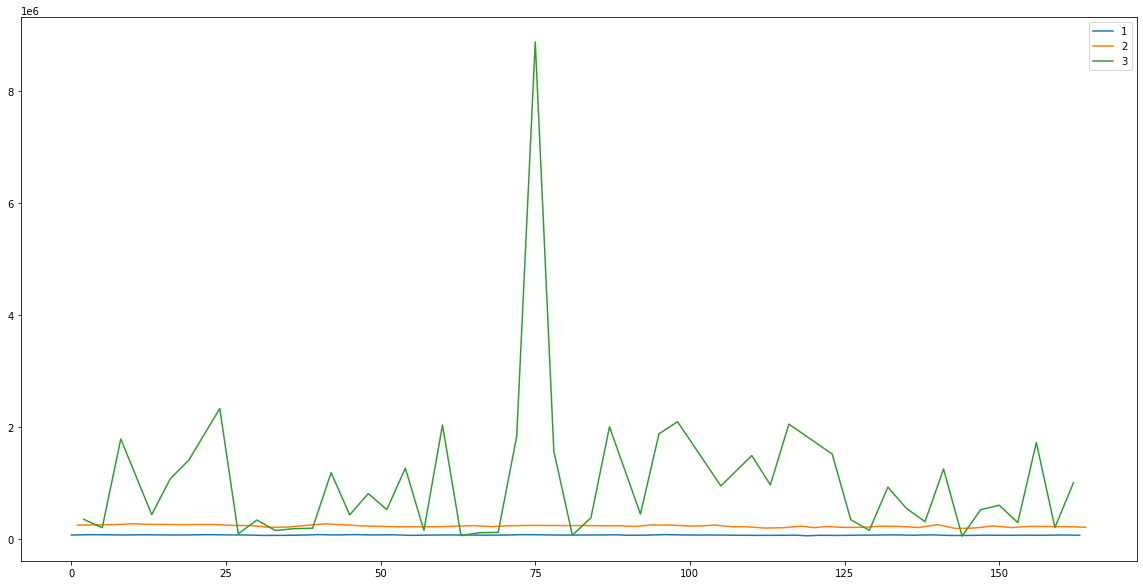

In [234]:
plt.rcParams['figure.figsize'] = [20, 10]
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [235]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_TR = df_clustering_TR.append(df_noact).append(df_ni)

df_export_TR['CLUSTER'] = 'OTROS'
df_export_TR.loc[(df_export_TR['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_TR.loc[(df_export_TR['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_TR.loc[(df_export_TR['CLUSTER_ID'] == 1), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_TR.loc[(df_export_TR['CLUSTER_ID'] == 2), 'CLUSTER'] = 'MANTIENEN MEDIO'
df_export_TR.loc[(df_export_TR['CLUSTER_ID'] == 3), 'CLUSTER'] = 'ATIPICO'

print(df_export_TR['CLUSTER'].value_counts())
print(sum(df_export_TR['CLUSTER'].value_counts()))

MANTIENEN BAJO     656
MANTIENEN MEDIO    156
NI                  35
ATIPICO              1
NA                   1
Name: CLUSTER, dtype: int64
849


## Tienda Ventana

In [236]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'TV']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 192
Número de clientes ACTIVOS: 192
Número de clientes NO ACTIVOS: 0
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 181


In [237]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [242]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 4*1000000, criterion='distance')

df_clustering_TV = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_TV, on='ID_CLIENTE', how='left')
df_clustering_TV['CLUSTER_ID'].value_counts()

1    173
2      7
3      1
Name: CLUSTER_ID, dtype: int64

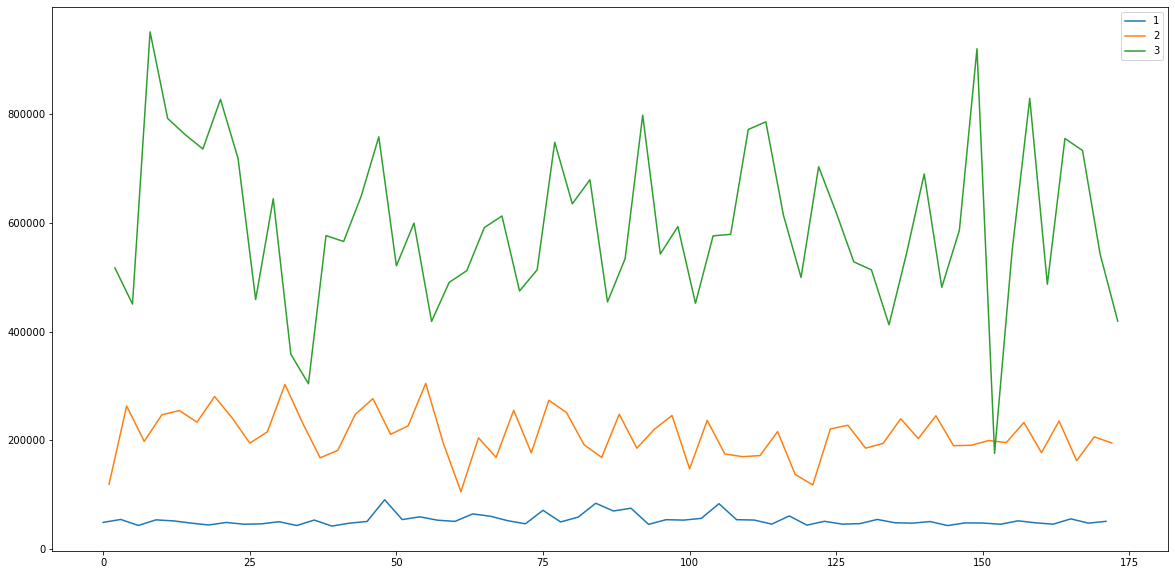

In [243]:
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [244]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_TV = df_clustering_TV.append(df_noact).append(df_ni)

df_export_TV['CLUSTER'] = 'OTROS'
df_export_TV.loc[(df_export_TV['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_TV.loc[(df_export_TV['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_TV.loc[(df_export_TV['CLUSTER_ID'] == 1), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_TV.loc[(df_export_TV['CLUSTER_ID'] == 2), 'CLUSTER'] = 'MANTIENEN MEDIO'
df_export_TV.loc[(df_export_TV['CLUSTER_ID'] == 3), 'CLUSTER'] = 'MANTIENEN ALTO'

print(df_export_TV['CLUSTER'].value_counts())
print(sum(df_export_TV['CLUSTER'].value_counts()))

MANTIENEN BAJO     173
NI                  11
MANTIENEN MEDIO      7
MANTIENEN ALTO       1
Name: CLUSTER, dtype: int64
192


## Panaderias

In [245]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'PN']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 503
Número de clientes ACTIVOS: 502
Número de clientes NO ACTIVOS: 1
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 491


In [246]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [247]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 7*1000000, criterion='distance')

df_clustering_PN = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_PN, on='ID_CLIENTE', how='left')
df_clustering_PN['CLUSTER_ID'].value_counts()

1    291
3    122
4     66
2     12
Name: CLUSTER_ID, dtype: int64

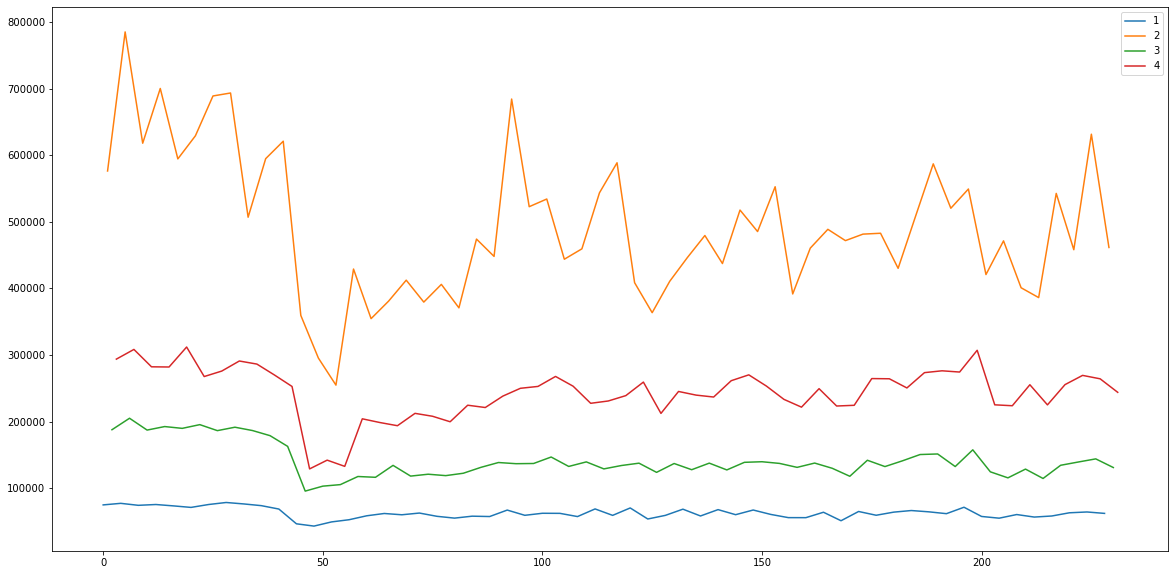

In [248]:
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [249]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_PN = df_clustering_PN.append(df_noact).append(df_ni)

df_export_PN['CLUSTER'] = 'OTROS'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == 1), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == 2), 'CLUSTER'] = 'SUBEN ALTO'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == 3), 'CLUSTER'] = 'MANTIENEN MEDIO'
df_export_PN.loc[(df_export_PN['CLUSTER_ID'] == 4), 'CLUSTER'] = 'MANTIENEN ALTO'

print(df_export_PN['CLUSTER'].value_counts())
print(sum(df_export_PN['CLUSTER'].value_counts()))

MANTIENEN BAJO     291
MANTIENEN MEDIO    122
MANTIENEN ALTO      66
SUBEN ALTO          12
NI                  11
NA                   1
Name: CLUSTER, dtype: int64
503


## Producto Frescos

In [250]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'PF']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 555
Número de clientes ACTIVOS: 554
Número de clientes NO ACTIVOS: 1
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 519


In [251]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [252]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 15*1000000, criterion='distance')

df_clustering_PF = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_PF, on='ID_CLIENTE', how='left')
df_clustering_PF['CLUSTER_ID'].value_counts()

2    382
3    129
1      8
Name: CLUSTER_ID, dtype: int64

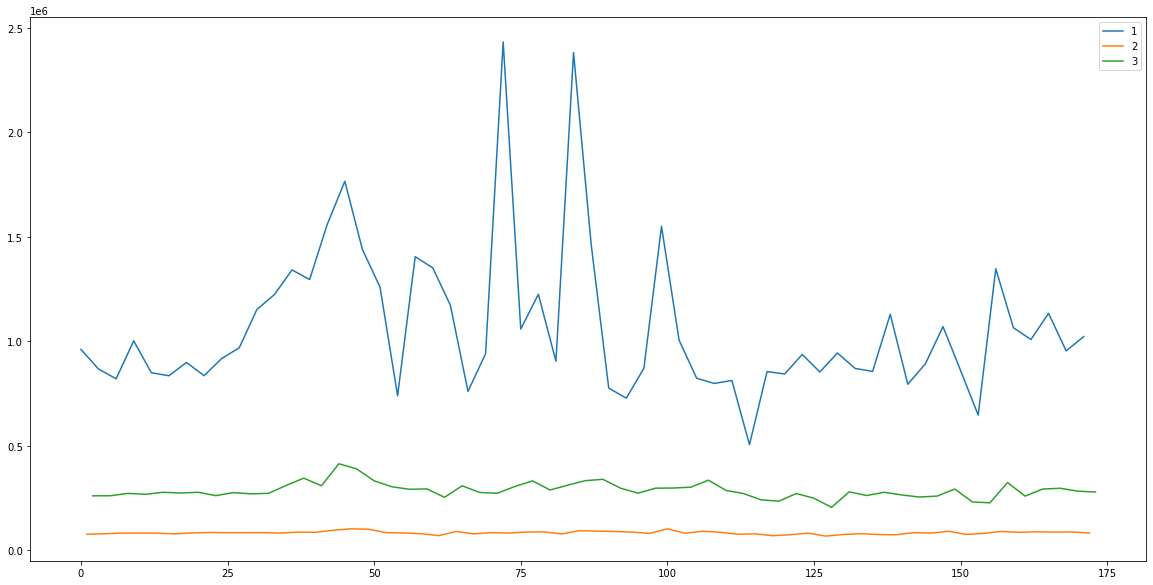

In [253]:
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [254]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_PF = df_clustering_PF.append(df_noact).append(df_ni)

df_export_PF['CLUSTER'] = 'OTROS'
df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == 1), 'CLUSTER'] = 'SUBEN ALTO'
df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == 2), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == 3), 'CLUSTER'] = 'MANTIENEN MEDIO'
#df_export_PF.loc[(df_export_PF['CLUSTER_ID'] == 4), 'CLUSTER'] = 'ATIPICO'

print(df_export_PF['CLUSTER'].value_counts())
print(sum(df_export_PF['CLUSTER'].value_counts()))

MANTIENEN BAJO     382
MANTIENEN MEDIO    129
NI                  35
SUBEN ALTO           8
NA                   1
Name: CLUSTER, dtype: int64
555


## Autoservicios

In [255]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'AT']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 162
Número de clientes ACTIVOS: 162
Número de clientes NO ACTIVOS: 0
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 151


In [256]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [257]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 20*1000000, criterion='distance')

df_clustering_AT = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_AT, on='ID_CLIENTE', how='left')
df_clustering_AT['CLUSTER_ID'].value_counts()

1    111
2     26
3     13
4      1
Name: CLUSTER_ID, dtype: int64

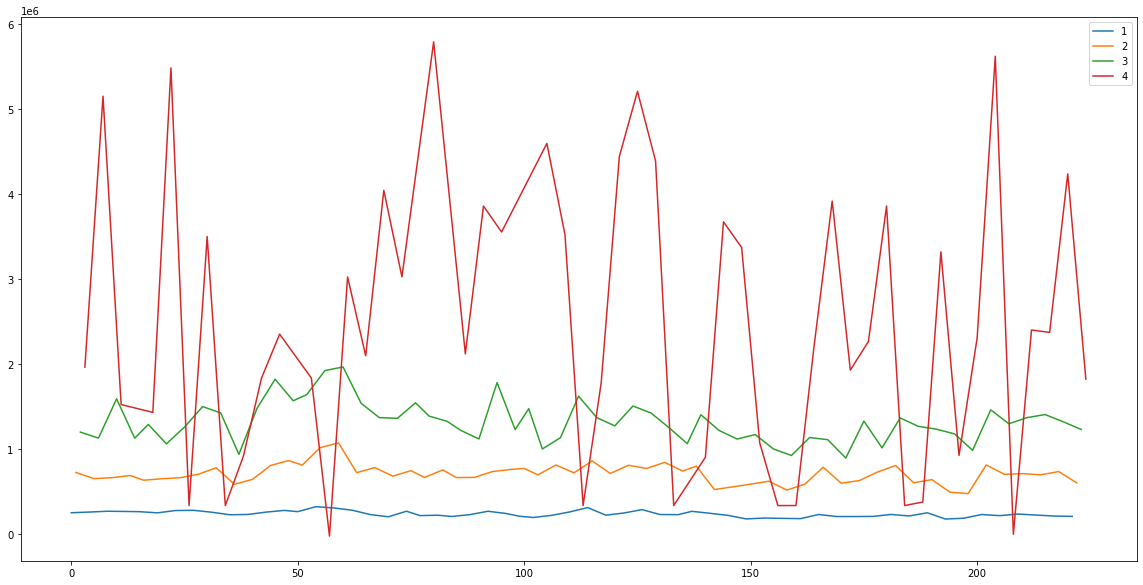

In [258]:
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [259]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_AT = df_clustering_AT.append(df_noact).append(df_ni)

df_export_AT['CLUSTER'] = 'OTROS'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == 1), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == 2), 'CLUSTER'] = 'MANTIENEN MEDIO'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == 3), 'CLUSTER'] = 'SUBEN ALTO'
df_export_AT.loc[(df_export_AT['CLUSTER_ID'] == 4), 'CLUSTER'] = 'ATIPICO'

print(df_export_AT['CLUSTER'].value_counts())
print(sum(df_export_AT['CLUSTER'].value_counts()))

MANTIENEN BAJO     111
MANTIENEN MEDIO     26
SUBEN ALTO          13
NI                  11
ATIPICO              1
Name: CLUSTER, dtype: int64
162


## CL

In [260]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'CL']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 396
Número de clientes ACTIVOS: 389
Número de clientes NO ACTIVOS: 7
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 368


In [261]:
df_clust = df_tipo[df_tipo['ID_CLIENTE'].isin(client_clust)]
df_clust.sort_values(['ID_CLIENTE','WEEK'], inplace=True)

labels   = np.array(df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).index)
df_list = df_clust.groupby('ID_CLIENTE')['VENTA'].apply(list).values.tolist()
n       = max(map(len, df_list))
series  = np.array([i + [0]*(n-len(i)) for i in df_list])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [262]:
Z = ward(pdist(series))
cluster_output = fcluster(Z, t = 3*1000000, criterion='distance')

df_clustering_CL = pd.DataFrame({'ID_CLIENTE': labels, 'CLUSTER_ID': cluster_output})
df_model = df_clust.merge(df_clustering_CL, on='ID_CLIENTE', how='left')
df_clustering_CL['CLUSTER_ID'].value_counts()

1    348
2     17
3      2
4      1
Name: CLUSTER_ID, dtype: int64

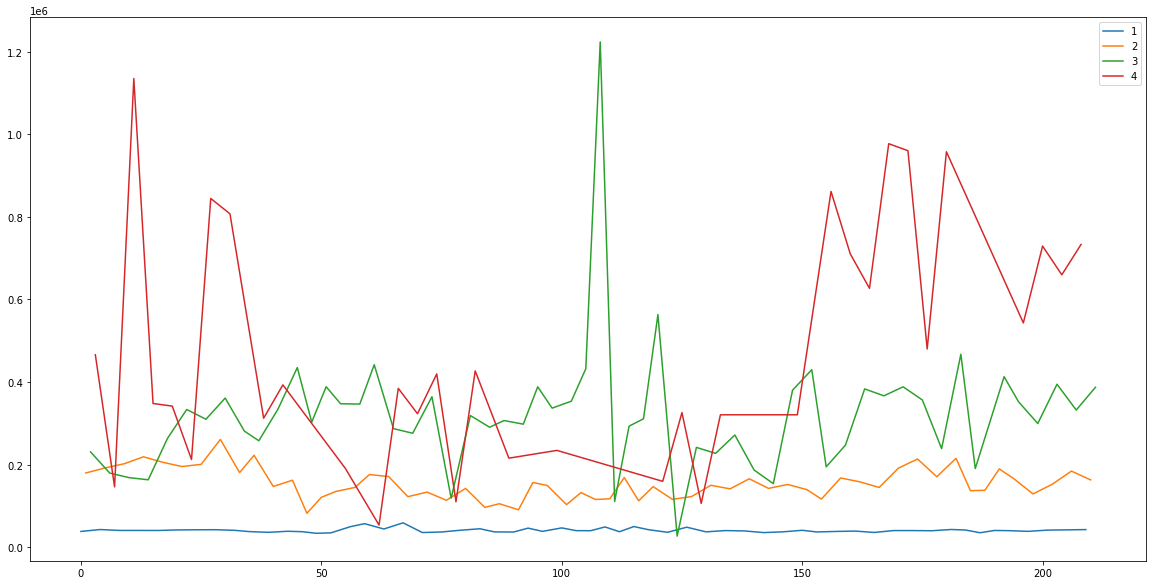

In [263]:
df_desc = df_model.groupby(["WEEK", "CLUSTER_ID"])["VENTA"].mean()
df_desc = df_desc.add_suffix('').reset_index()
df_desc.columns = ["WEEK", "CLUSTER_ID", "VENTA"]
df_desc = df_desc.sort_values(by=["WEEK", "CLUSTER_ID"], ascending=True)

df_desc.groupby('CLUSTER_ID')['VENTA'].plot(legend='True')
plt.show()

In [264]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': -1})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_export_CL = df_clustering_CL.append(df_noact).append(df_ni)

df_export_CL['CLUSTER'] = 'OTROS'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == -1), 'CLUSTER'] = 'NI'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == 1), 'CLUSTER'] = 'MANTIENEN BAJO'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == 2), 'CLUSTER'] = 'MANTIENEN MEDIO'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == 3), 'CLUSTER'] = 'SUBEN MEDIO'
df_export_CL.loc[(df_export_CL['CLUSTER_ID'] == 4), 'CLUSTER'] = 'SUBEN ALTO'

print(df_export_CL['CLUSTER'].value_counts())
print(sum(df_export_CL['CLUSTER'].value_counts()))

MANTIENEN BAJO     348
NI                  21
MANTIENEN MEDIO     17
NA                   7
SUBEN MEDIO          2
SUBEN ALTO           1
Name: CLUSTER, dtype: int64
396


## Otros

In [265]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'CN']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 6
Número de clientes ACTIVOS: 4
Número de clientes NO ACTIVOS: 2
************ Semanas ************
Número de semanas que se tienen: 58
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 4


In [266]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': 0})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_otro_CN   = pd.DataFrame({'ID_CLIENTE': client_clust, 'CLUSTER_ID': 0})

df_export_CN = df_otro_CN.append(df_noact).append(df_ni)

df_export_CN['CLUSTER'] = 'OTROS'
df_export_CN.loc[(df_export_CN['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'

print(df_export_CN['CLUSTER'].value_counts())
print(sum(df_export_CN['CLUSTER'].value_counts()))

NA    6
Name: CLUSTER, dtype: int64
6


In [267]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'CG']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 0
Número de clientes ACTIVOS: 0
Número de clientes NO ACTIVOS: 0
************ Semanas ************
Número de semanas que se tienen: nan
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 0


In [268]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': 0})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_otro_CG   = pd.DataFrame({'ID_CLIENTE': client_clust, 'CLUSTER_ID': 0})

df_export_CG = df_otro_CG.append(df_noact).append(df_ni)

df_export_CG['CLUSTER'] = 'OTROS'
df_export_CG.loc[(df_export_CG['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'

print(df_export_CG['CLUSTER'].value_counts())
print(sum(df_export_CG['CLUSTER'].value_counts()))

Series([], Name: CLUSTER, dtype: int64)
0


In [269]:
df_tipo = data_frame[data_frame['TIPOLOGIA'] == 'SL']

print("************ Clientes ************")
client_tot = df_tipo['ID_CLIENTE'].unique()
print("Número de clientes TOTALES:", client_tot.shape[0])

client_act = df_tipo[df_tipo['WEEK'] >= datetime.date(2020,11,1)]['ID_CLIENTE']
client_act = client_act.unique()
print("Número de clientes ACTIVOS:", client_act.shape[0])

client_nact = df_tipo[~df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE']
client_nact = client_nact.unique()
print("Número de clientes NO ACTIVOS:", client_nact.shape[0])

print("************ Semanas ************")
df_client = df_tipo[df_tipo['ID_CLIENTE'].isin(client_act)]['ID_CLIENTE'].value_counts()
df_client = df_client.add_suffix('').reset_index()
df_client.columns = ['ID_CLIENTE', 'n']
df_client = df_client.sort_values(by=['n'], ascending=False)
print("Número de semanas que se tienen:", df_client['n'].max())
#print(df_client['n'].value_counts())

print("************ Cluster ************")
client_ni = np.array(df_client[df_client['n'] < 8]['ID_CLIENTE'])
print("Número de clientes que NO tienen información:", client_cl3.shape[0])

client_clust = np.array(df_client[df_client['n'] >= 8]['ID_CLIENTE'])
print("Número de clientes con información:", client_clust.shape[0])

************ Clientes ************
Número de clientes TOTALES: 0
Número de clientes ACTIVOS: 0
Número de clientes NO ACTIVOS: 0
************ Semanas ************
Número de semanas que se tienen: nan
************ Cluster ************
Número de clientes que NO tienen información: 184
Número de clientes con información: 0


In [270]:
df_ni        = pd.DataFrame({'ID_CLIENTE': client_ni, 'CLUSTER_ID': 0})
df_noact     = pd.DataFrame({'ID_CLIENTE': client_nact, 'CLUSTER_ID': 0})
df_otro_SL   = pd.DataFrame({'ID_CLIENTE': client_clust, 'CLUSTER_ID': 0})

df_export_SL = df_otro_SL.append(df_noact).append(df_ni)

df_export_SL['CLUSTER'] = 'OTROS'
df_export_SL.loc[(df_export_SL['CLUSTER_ID'] == 0), 'CLUSTER'] = 'NA'

print(df_export_SL['CLUSTER'].value_counts())
print(sum(df_export_SL['CLUSTER'].value_counts()))

Series([], Name: CLUSTER, dtype: int64)
0


## Export

In [271]:
df_export = df_export_TR.append(df_export_TV).append(df_export_PN).append(df_export_PF).append(df_export_AT).append(df_export_CL).append(df_export_CN).append(df_export_CG).append(df_export_SL)
df_export.head()
print(df_export.shape)

(2663, 3)


In [272]:
pandas_gbq.to_gbq(df_export, 'INPUT.DF_CLUSTER_DIST_1', project_id = 'alq-analitica-dev', if_exists='fail')

1it [00:02,  2.97s/it]
